## Reflectance Fitting in Julia
This notebook demonstrates how to do reflectance fitting with Julia. It uses the actual code I used to analyze the AlF3 data in September 2018 as an example.

Steve Turley

### Macros
First, I want to see if I can remove some of the repetitive peices with macros which I'm just learning how to write.

In [1]:
# Initialization I need to test the other stuff
using ALS
using Serialization
import PyPlot
const plt = PyPlot;
using Test
using Printf
using LaTeXStrings
import DataFrames
import CSV

In [2]:
function read_data(initRead)
    if initRead
        # To initially read everything
        # This will take a long time
        global lf = LogFile()
        open("logfile.bin",write=true) do f
            serialize(f,lf)
        end     
        println("Reading all data files, please be patient...")
        global alldata = [Run(lf, rnum) for rnum = 1:ALS.runs(lf)];
        # Serialize it so it is faster next time
        open("alldata.bin",write=true) do f
            serialize(f, alldata)
        end
    else
        # Faster way if you already have the data
        open("alldata.bin") do f
            alldata = deserialize(f)
        end
        open("logfile.bin") do f
            lf = deserialize(f)
        end
    end
end

read_data (generic function with 1 method)

In [3]:
# @time read_data(true);
@time read_data(false);

  6.403111 seconds (15.43 M allocations: 758.033 MiB, 11.49% gc time)


### Plotting Dark Current

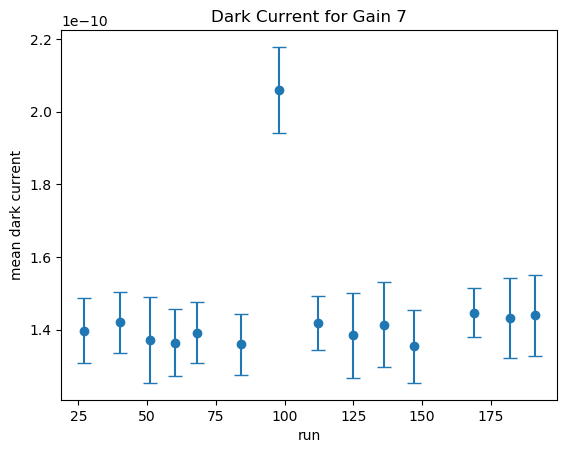

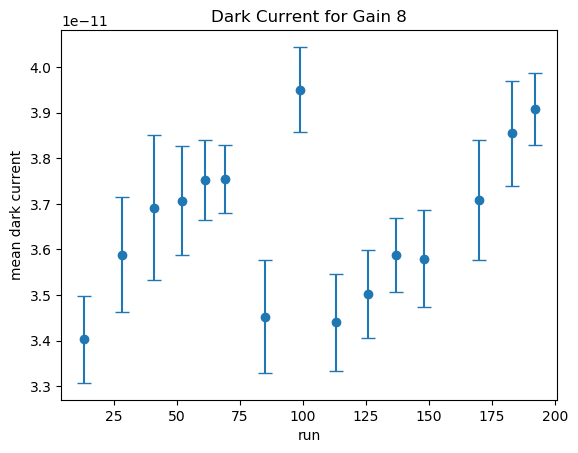

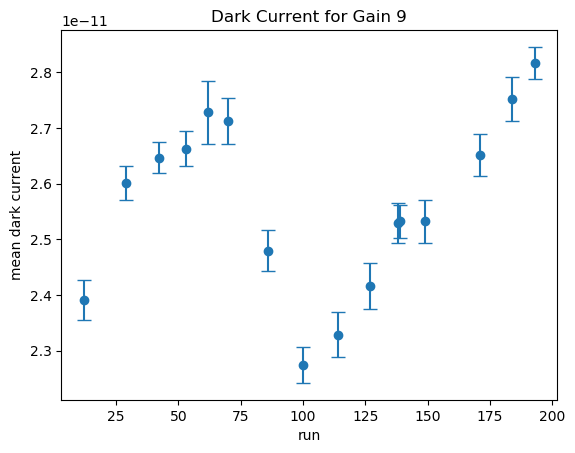

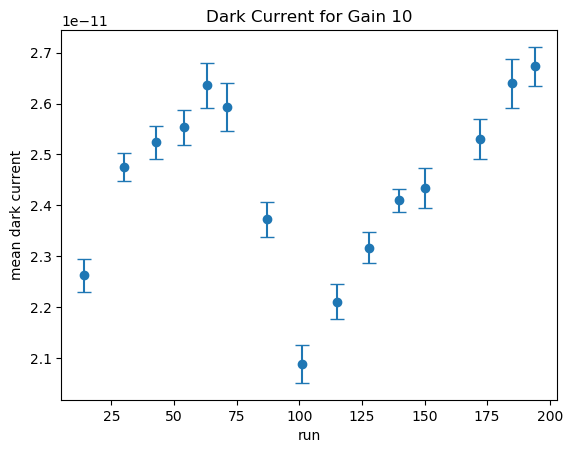

PyObject Text(24,0.5,'mean dark current')

In [4]:
gain7_runs = (27, 40, 51, 60, 68, 84, 98, 112, 125, 136, 147, 169, 182, 191)
gain8_runs = (13, 28, 41, 52, 61, 69, 85, 99, 113, 126, 137, 148, 170, 183, 192)
gain9_runs = (12, 29, 42, 53, 62, 70, 86, 100, 114, 127, 138, 139, 149, 171, 184, 193)
gain10_runs = (14, 30, 43, 54, 63, 71, 87, 101, 115, 128, 140, 150, 172, 185, 194)

function dplot(runList, gain::Int)
    
    mean(run::Int) = sum(alldata[run].det)/length(alldata[run].det)
    
    function std(run::Int)
        avg = mean(run)
        avg2 = sum(abs2, alldata[run].det)/length(alldata[run].det)
        sqrt(avg2-avg^2)
    end
    
    x = runList
    y = mean.(runList)
    vy = std.(runList)
    plt.figure()
    plt.errorbar(x, y, vy, fmt="o", capsize=5)
    plt.title("Dark Current for Gain $gain")
    plt.xlabel("run")
    plt.ylabel("mean dark current")
end

dplot(gain7_runs, 7)
dplot(gain8_runs, 8)
dplot(gain9_runs, 9)
dplot(gain10_runs, 10)

In [5]:
function order_sorter(i0_run::Int64, dark_runs::UnitRange{Int64})
    global i0data = alldata[i0_run]
    global dark=Dict{Int64,Run}()
    for r in dark_runs
        run = alldata[r]
        dark[gain(run)] = run
    end
    global dark0 = dark[gain(i0data)]
end

order_sorter (generic function with 1 method)

In [6]:
order_sorter(26,27:30)
@testset "Order Sorter" begin
@test i0data.npts == 53
@test dark0.npts == 31
@test dark[8].npts == 31
end;

Test Summary: | Pass  Total
Order Sorter  |    3      3


The `refl` array are the reflectances which are used for fitting. The `refl_dup` array has duplicate measurements which are not used for fitting.

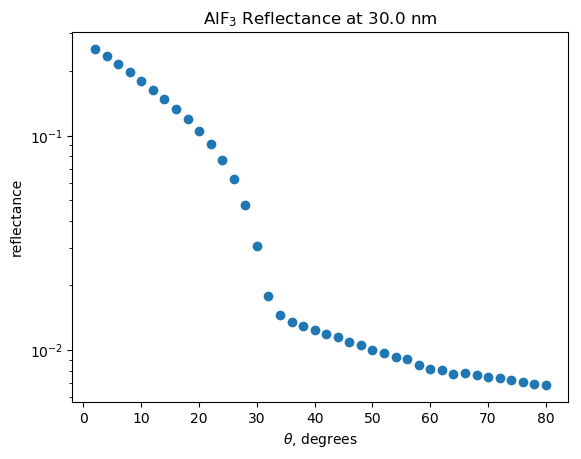

PyObject Text(24,0.5,'reflectance')

In [7]:
refl = Dict{Float64,Reflectance}()
order_sorter(26,27:30)
function creflect(irun::Int64, dup=false)
    i = alldata[irun]
    lambda = wavelength(i)
    if lambda<i0data.x[1] lambda = i0data.x[1] end
    if lambda>i0data.x[end] lambda = i0data.x[end] end
    g = gain(i)
    nice_wavelength = trunc(lambda, digits=1)
    # Find the cut-off wavelength
    j = 1
    while i.det[j] < i.det[j+1]
        j += 1
    end
    cutoff = i.x[j]
    if dup
        refl_dup[nice_wavelength] =
            sub(Reflectance(i, i0data, dark[g], dark0, lambda), min=cutoff);
    else
        refl[nice_wavelength] = 
            sub(Reflectance(i, i0data, dark[g], dark0, lambda), min=cutoff)
    end
end
creflect(19)
rplot(refl[30])

In [8]:
refl = Dict{Float64,Reflectance}()
refl_dup = Dict{Float64,Reflectance}()
order_sorter(11,12:13);
for i in 19:25 creflect(i); end;
order_sorter(26,27:28);
for i in 31:34 creflect(i, true) end;
for i in 35:38 creflect(i); end;
order_sorter(39,40:41)
for i in 44:45 creflect(i, true) end;
creflect(46)
for i in 47:49 creflect(i, true) end;
order_sorter(50,51:52)
creflect(55, true)
for i in (56:58) creflect(i) end;
order_sorter(59,60:60)
creflect(64, true)
for i in 65:66 creflect(i); end;

Plot the data for the runs which will be fit.

In [9]:
# helpful functions for creating filename strings for runs
function runstr(lambda::Real, prefix::AbstractString, postfix::AbstractString="")
    lamf = trunc(lambda)
    lamd = round(lambda,digits=1)-lamf
    if lamd == 0.0
        @sprintf("SampleA/%s%.0f%s.png",prefix,lamf,postfix)
    else
        @sprintf("SampleA/%s%.0fp%.0f%s.png",prefix,lamf,lamd*10,postfix)
    end
end
# Test a few cases
@testset "Testing Filenames" begin
    @test runstr(9, "dfit") == "SampleA/dfit9.png"
    @test runstr(10.7, "dfit") == "SampleA/dfit10p7.png"
    @test runstr(12, "a", "olap") == "SampleA/a12olap.png"
    @test runstr(11.3,"at","olap") == "SampleA/at11p3olap.png"
end;

Test Summary:     | Pass  Total
Testing Filenames |    4      4


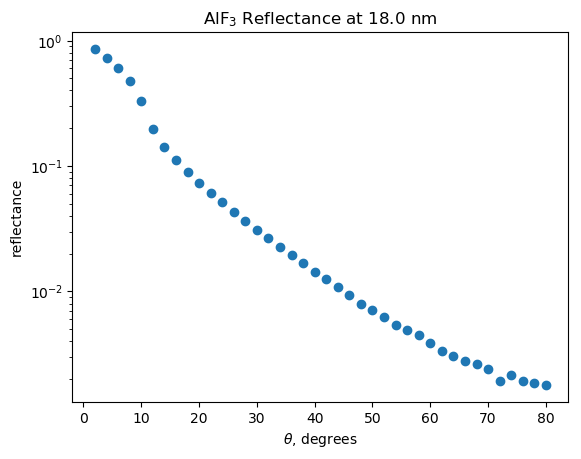

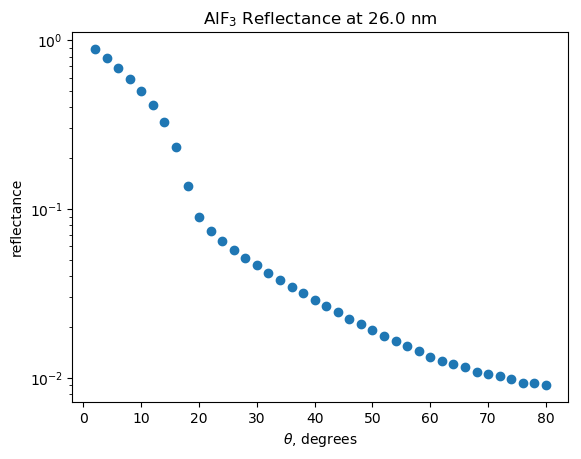

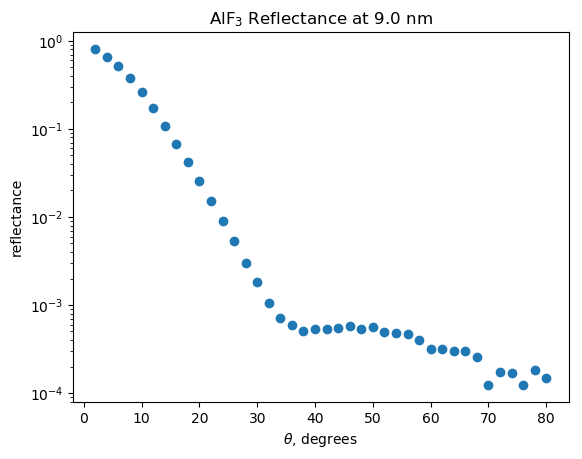

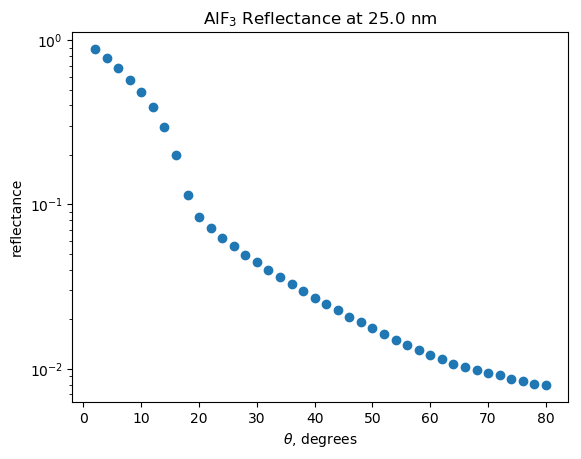

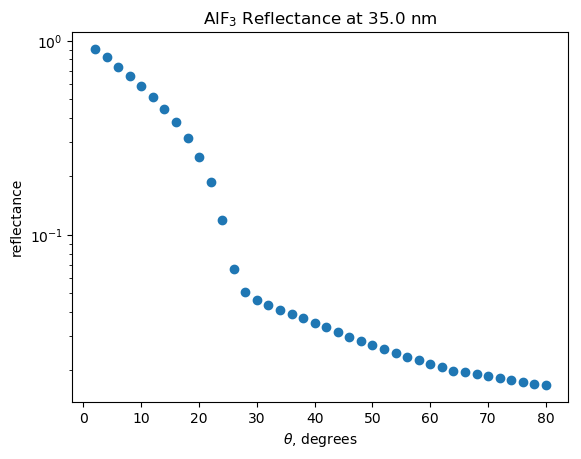

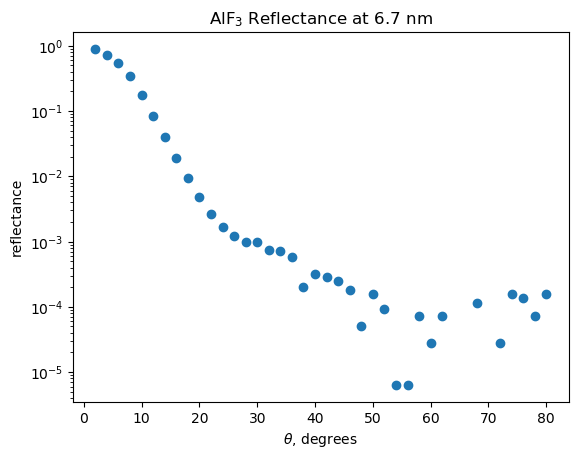

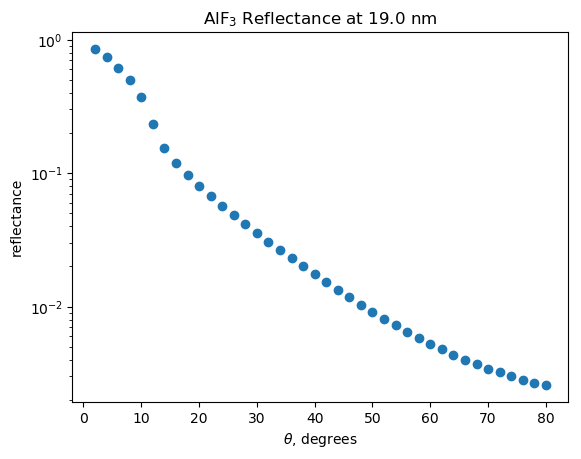

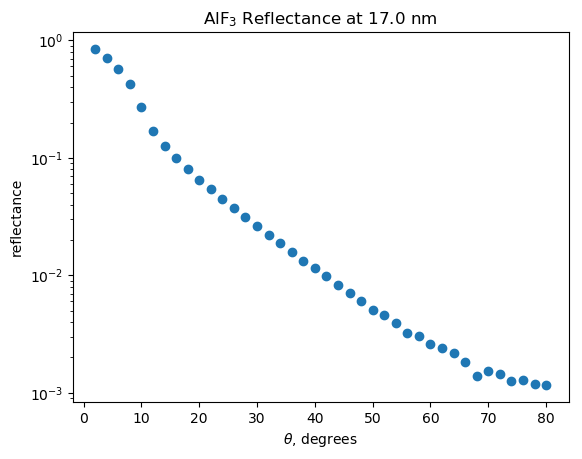

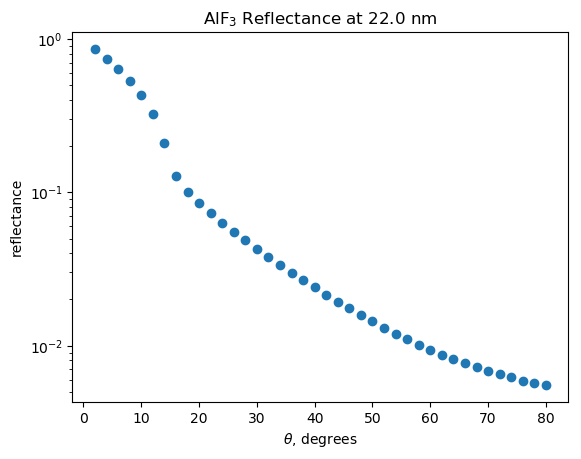

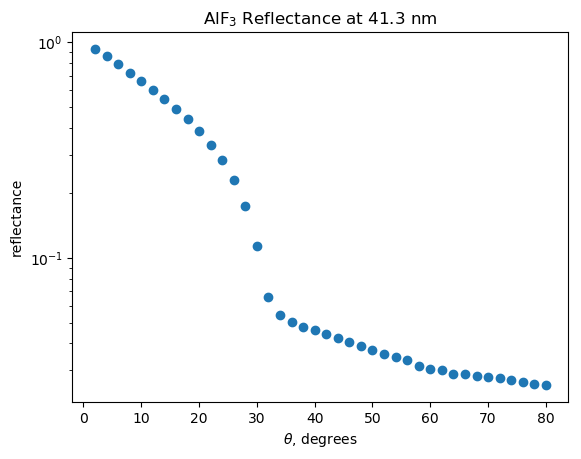

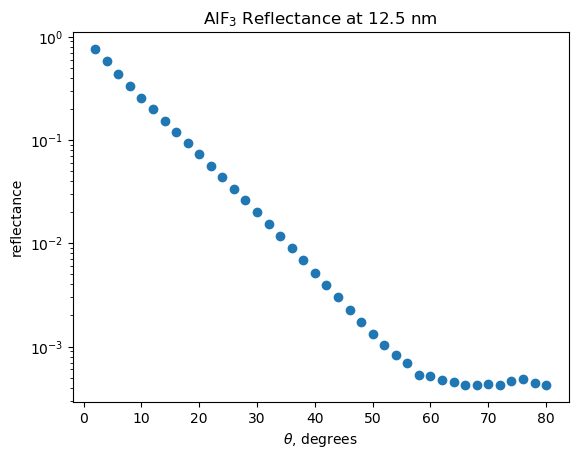

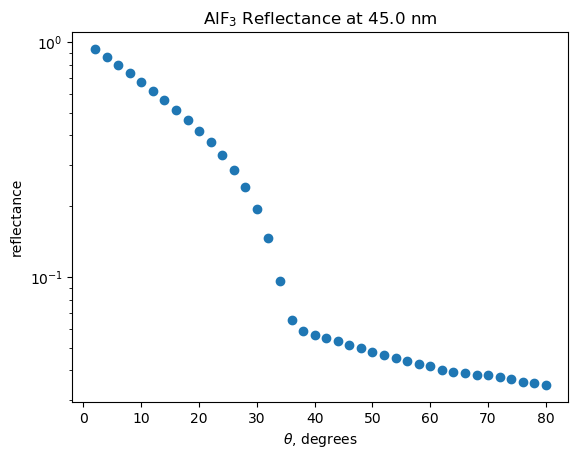

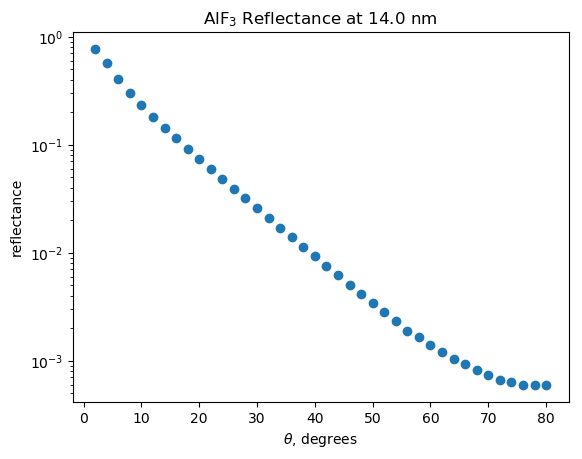

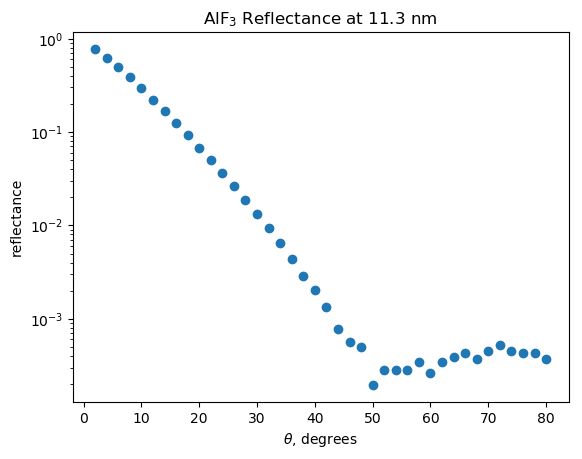

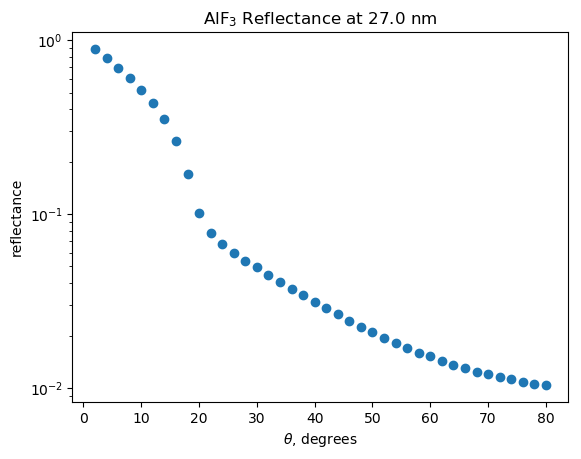

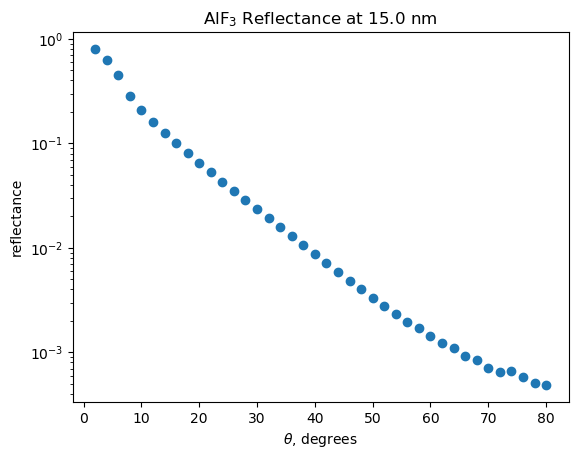

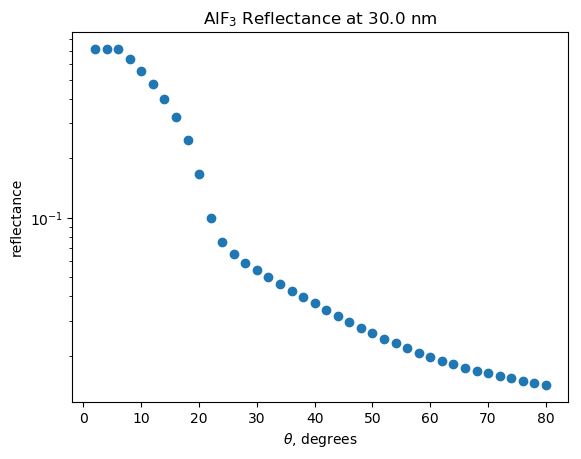

In [10]:
for (wl,rfl) in refl
    rplot(rfl)
end

Plot the comparison spectra for duplicates

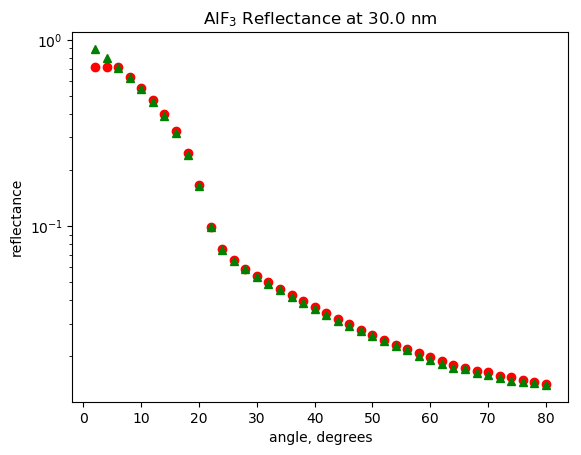

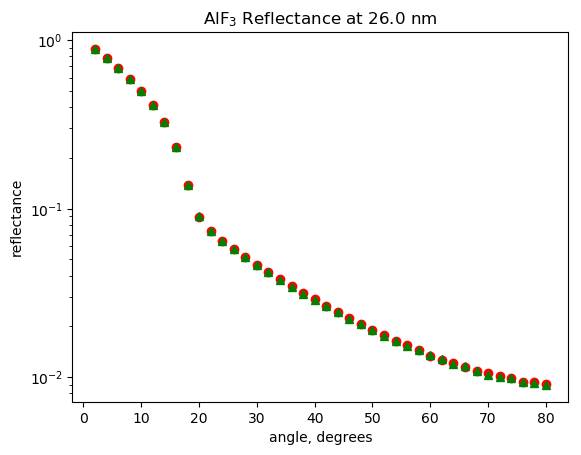

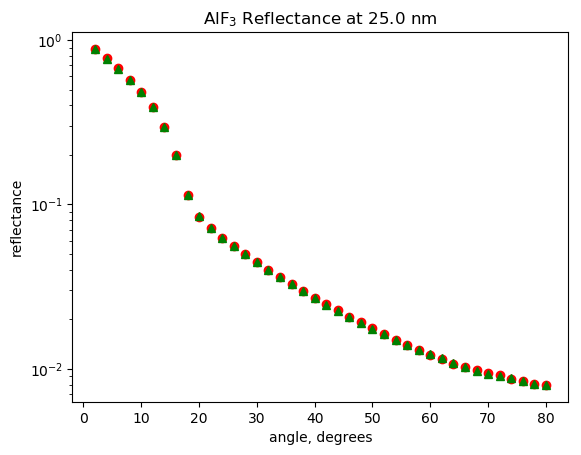

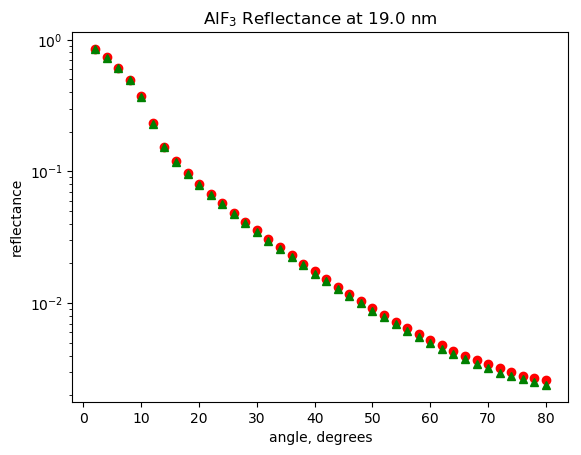

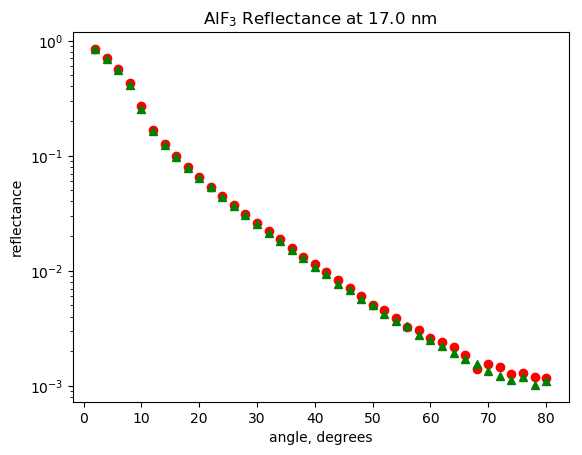

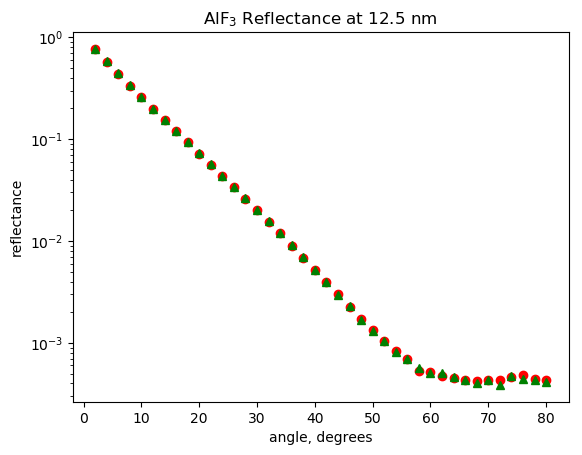

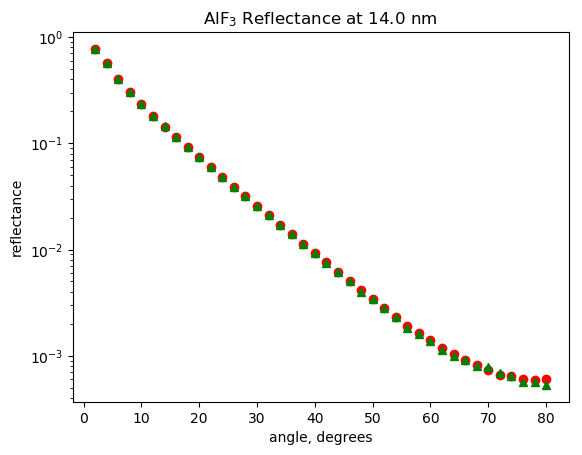

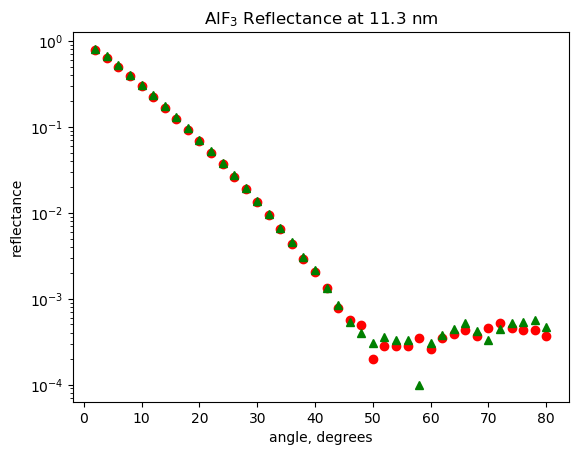

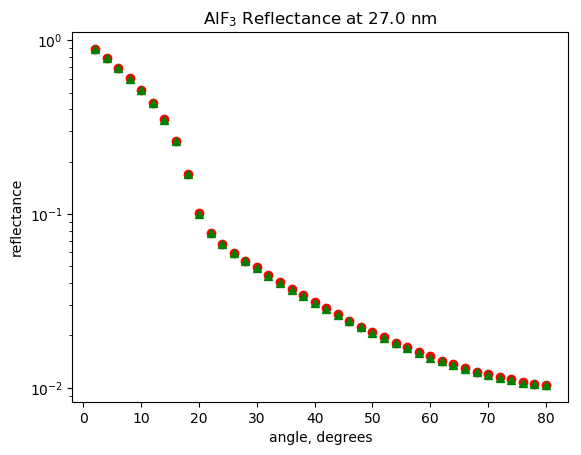

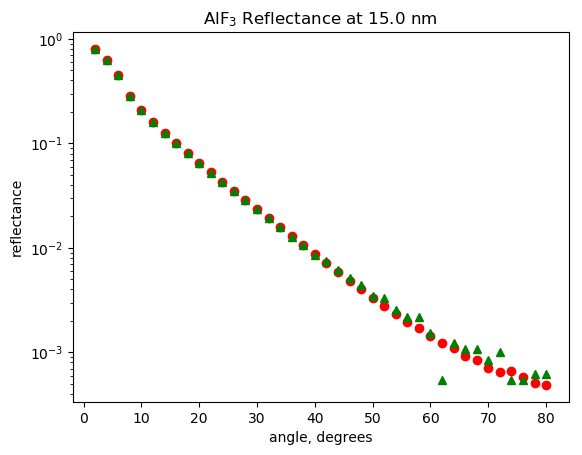

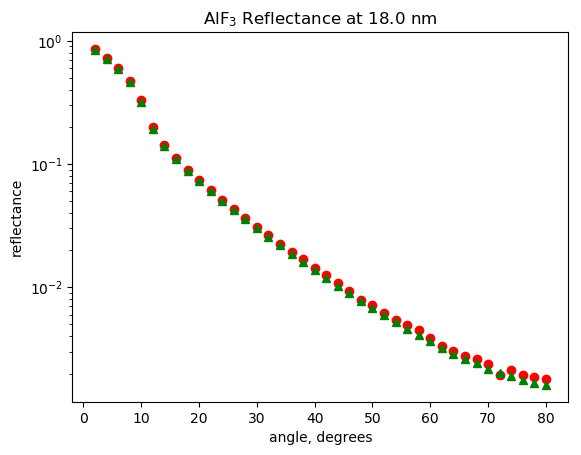

In [11]:
for (wl,rflb) in refl_dup
    plot2(refl[wl], rflb)
    plt.savefig(runstr(wl, "a","olap"))
end

Fix beginning points at 30.0 nm.

In [12]:
refl[30].theta[1:5]

5-element Array{Float64,1}:
  2.0
  4.0
  6.0
  8.0
 10.0

In [13]:
refl[30] = sub(refl[30],min=5.0); # Drop 2 and 4 degrees

### Fitting Data
I am using an updated fitting algorithm from what I used in the analysis. It will be interesting to see how the answers compare.

Constants and initial guesses.

In [14]:
SiIndex = Index("Si");
SiO2Index = Index("SiO2");
AlF3Index = Index("AlF3");
tSiO2 = 1.6; # nm
tAlF3 = 5.5; # nm
# Plotting and printing options
const initFitPlots = false
# If true, final fit plots are shown
const finalFitPlots = true
# If true, residual plots are shown
const residPlots = false
# If true, the composit plots are shown
const compositePlots = false
# If true, run summary information is printed
const showSummary = false
# If true, the plots for fitting all parameters are shown
const showThickFit = false
# If true, the plots for fitting with fixed thickness are shown
const showFixedThickFit = true

true

In [15]:
"""
    fitit(rfl [,perr=0.0])

# Parameters
* rfl: Reflectance with data to fit

* perr: optional, some fits won't work if the initial guess is too good. The normal original parameter guesses are multipied by (1+perr) to try the fit with poorer guesses.
"""
function fitit(rfl::Reflectance; perr=0.0)
    lambda = rfl.wavelength # nm
    sio2Ndx = SiO2Index[lambda];
    siNdx = SiIndex[lambda]
    function model(x,p)
        n = [1.0, p[1]+p[2]*1im, sio2Ndx, siNdx]
        t = [0.0, p[3], tSiO2, 0.0]
        [parratt(n, t, theta, lambda) for theta in x]
    end
    thetad = rfl.theta
    alf3Ndx = AlF3Index[lambda]
    p = [real(alf3Ndx), imag(alf3Ndx), tAlF3]
    p = (1.0+perr).*p
    yp=model(thetad,p)
    fval = 0.03
    w=1.0./(fval.*rfl.refl);
    # w = ones(length(yp))
    if initFitPlots & showThickFit
        plt.figure()
        plt.semilogy(thetad, rfl.refl,"o",thetad,yp,"^");
        wl = round(lambda, digits=1)
        plt.title("Data and Initial Guess, \$\\lambda = \$$wl nm")
        plt.legend(["data", "initial guess"])
        plt.xlabel(L"$\theta$, degrees")
        plt.ylabel("reflectance")
    end
    # Currently good choices for optimizer are "BFGS" or "NelderMead"
    optimizer="NelderMead"
    # I had good luck with BackTracking. Other possibilities are
    # HagerZhang, MoreThuente
    linesearch = LineSearches.HagerZhang()
    mfit = curve_fit(model, thetad, rfl.refl, w, p, optimizer=optimizer,
        linesearch=linesearch);
    # Adjust weight to get MSE close to 1
    fval *= sqrt(mfit.mse)
    sig1 = fval.*rfl.refl;
    sig2 = 1e-4;
    w=1 ./ sqrt.(sig1.^2 .+ sig2^2)

    mfit = curve_fit(model, thetad, rfl.refl, w, p, optimizer=optimizer,
        linesearch=linesearch);
    rz = model(rfl.theta, mfit.param)
    rlam = round(lambda,digits=1)
    if finalFitPlots & showThickFit
        plt.figure()
        plt.semilogy(thetad, rfl.refl,"o", thetad, rz, "^");
        plt.title("Data and Fit, \$\\lambda = \$$rlam nm")
        plt.xlabel(L"$\theta$, degrees")
        plt.ylabel("reflectance")
        plt.legend(["data", "fit"])
        fname = runstr(lambda,"dfit")
        plt.savefig(fname)
    end
    (rlam, par[1], sig[1], par[2], sig[2], par[3], sig[3])
end

fitit (generic function with 1 method)

In [21]:
tdf = DataFrames.DataFrame(lambda=Float64[], n=Float64[], sn=Float64[], k=Float64[], sk=Float64[], t=Float64[], st=Float64[]);
for (i, (wl, r)) in enumerate(sort(refl))
    if !showSummary
        @printf("%d: lambda = %.1f\n", i, wl)
    end
    push!(tdf, fitit(r));
end
CSV.write("aThick.csv",tdf);

1: lambda = 6.7


ErrorException: Extrapolation not allowed

In [24]:
SiIndex[6.7]
SiO2Index[6.7]
AlF3Index[6.7]

ErrorException: Extrapolation not allowed

In [19]:
refl[18.0]

Reflectance([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0  …  62.0, 64.0, 66.0, 68.0, 70.0, 72.0, 74.0, 76.0, 78.0, 80.0], [0.856932, 0.725655, 0.598447, 0.471337, 0.330232, 0.197975, 0.141307, 0.11089, 0.0896884, 0.0736832  …  0.00336343, 0.0030448, 0.0027997, 0.00262813, 0.00240754, 0.00194184, 0.00213792, 0.00194184, 0.00186831, 0.00179478], 18.0001)

In [20]:
refl[18.0].wavelength

18.0001